## Classificação de áreas desmatadas através de Fully Convolutional Networks

Nesta prática, vamos fazer todas as etapas de uma classificação utilizando uma rede U-net.

In [1]:
import sys
sys.path.append("../src")
%load_ext autoreload
%autoreload 2

env: CUDA_VISIBLE_DEVICES=1,2,3


In [2]:
import numpy as np
import gdal
import os
from deepgeo.dataset import rasterizer
import deepgeo.dataset.preprocessor as prep
import deepgeo.common.geofunctions as gf
import deepgeo.common.visualization as vis
import deepgeo.dataset.dataset_generator as dg
import deepgeo.dataset.data_augment as dtaug
import deepgeo.networks.model_builder as mb

In [3]:
from pathlib import Path
#%% Load files
samples_path = Path('../data/chips/samples/')
labels_path = Path('../data/chips/labels/')
sample_files = [file for file in sorted(samples_path.glob('*.tif'))]
sample_imgs = []
label_imgs = []
for file in sample_files:    
    path_sample = file.resolve().as_posix()
    preproc = prep.Preprocessor(path_sample, no_data=-1)
    preproc.standardize_image('norm_range', {"min":0, "max":1})
    img_sample = preproc.get_array_stacked_raster()
    sample_imgs.append(img_sample)
    path_label = labels_path.joinpath(file.name).resolve().as_posix()
    img_label = gf.load_image(path_label,no_data=-1).astype(np.int32)
    label_imgs.append(img_label)


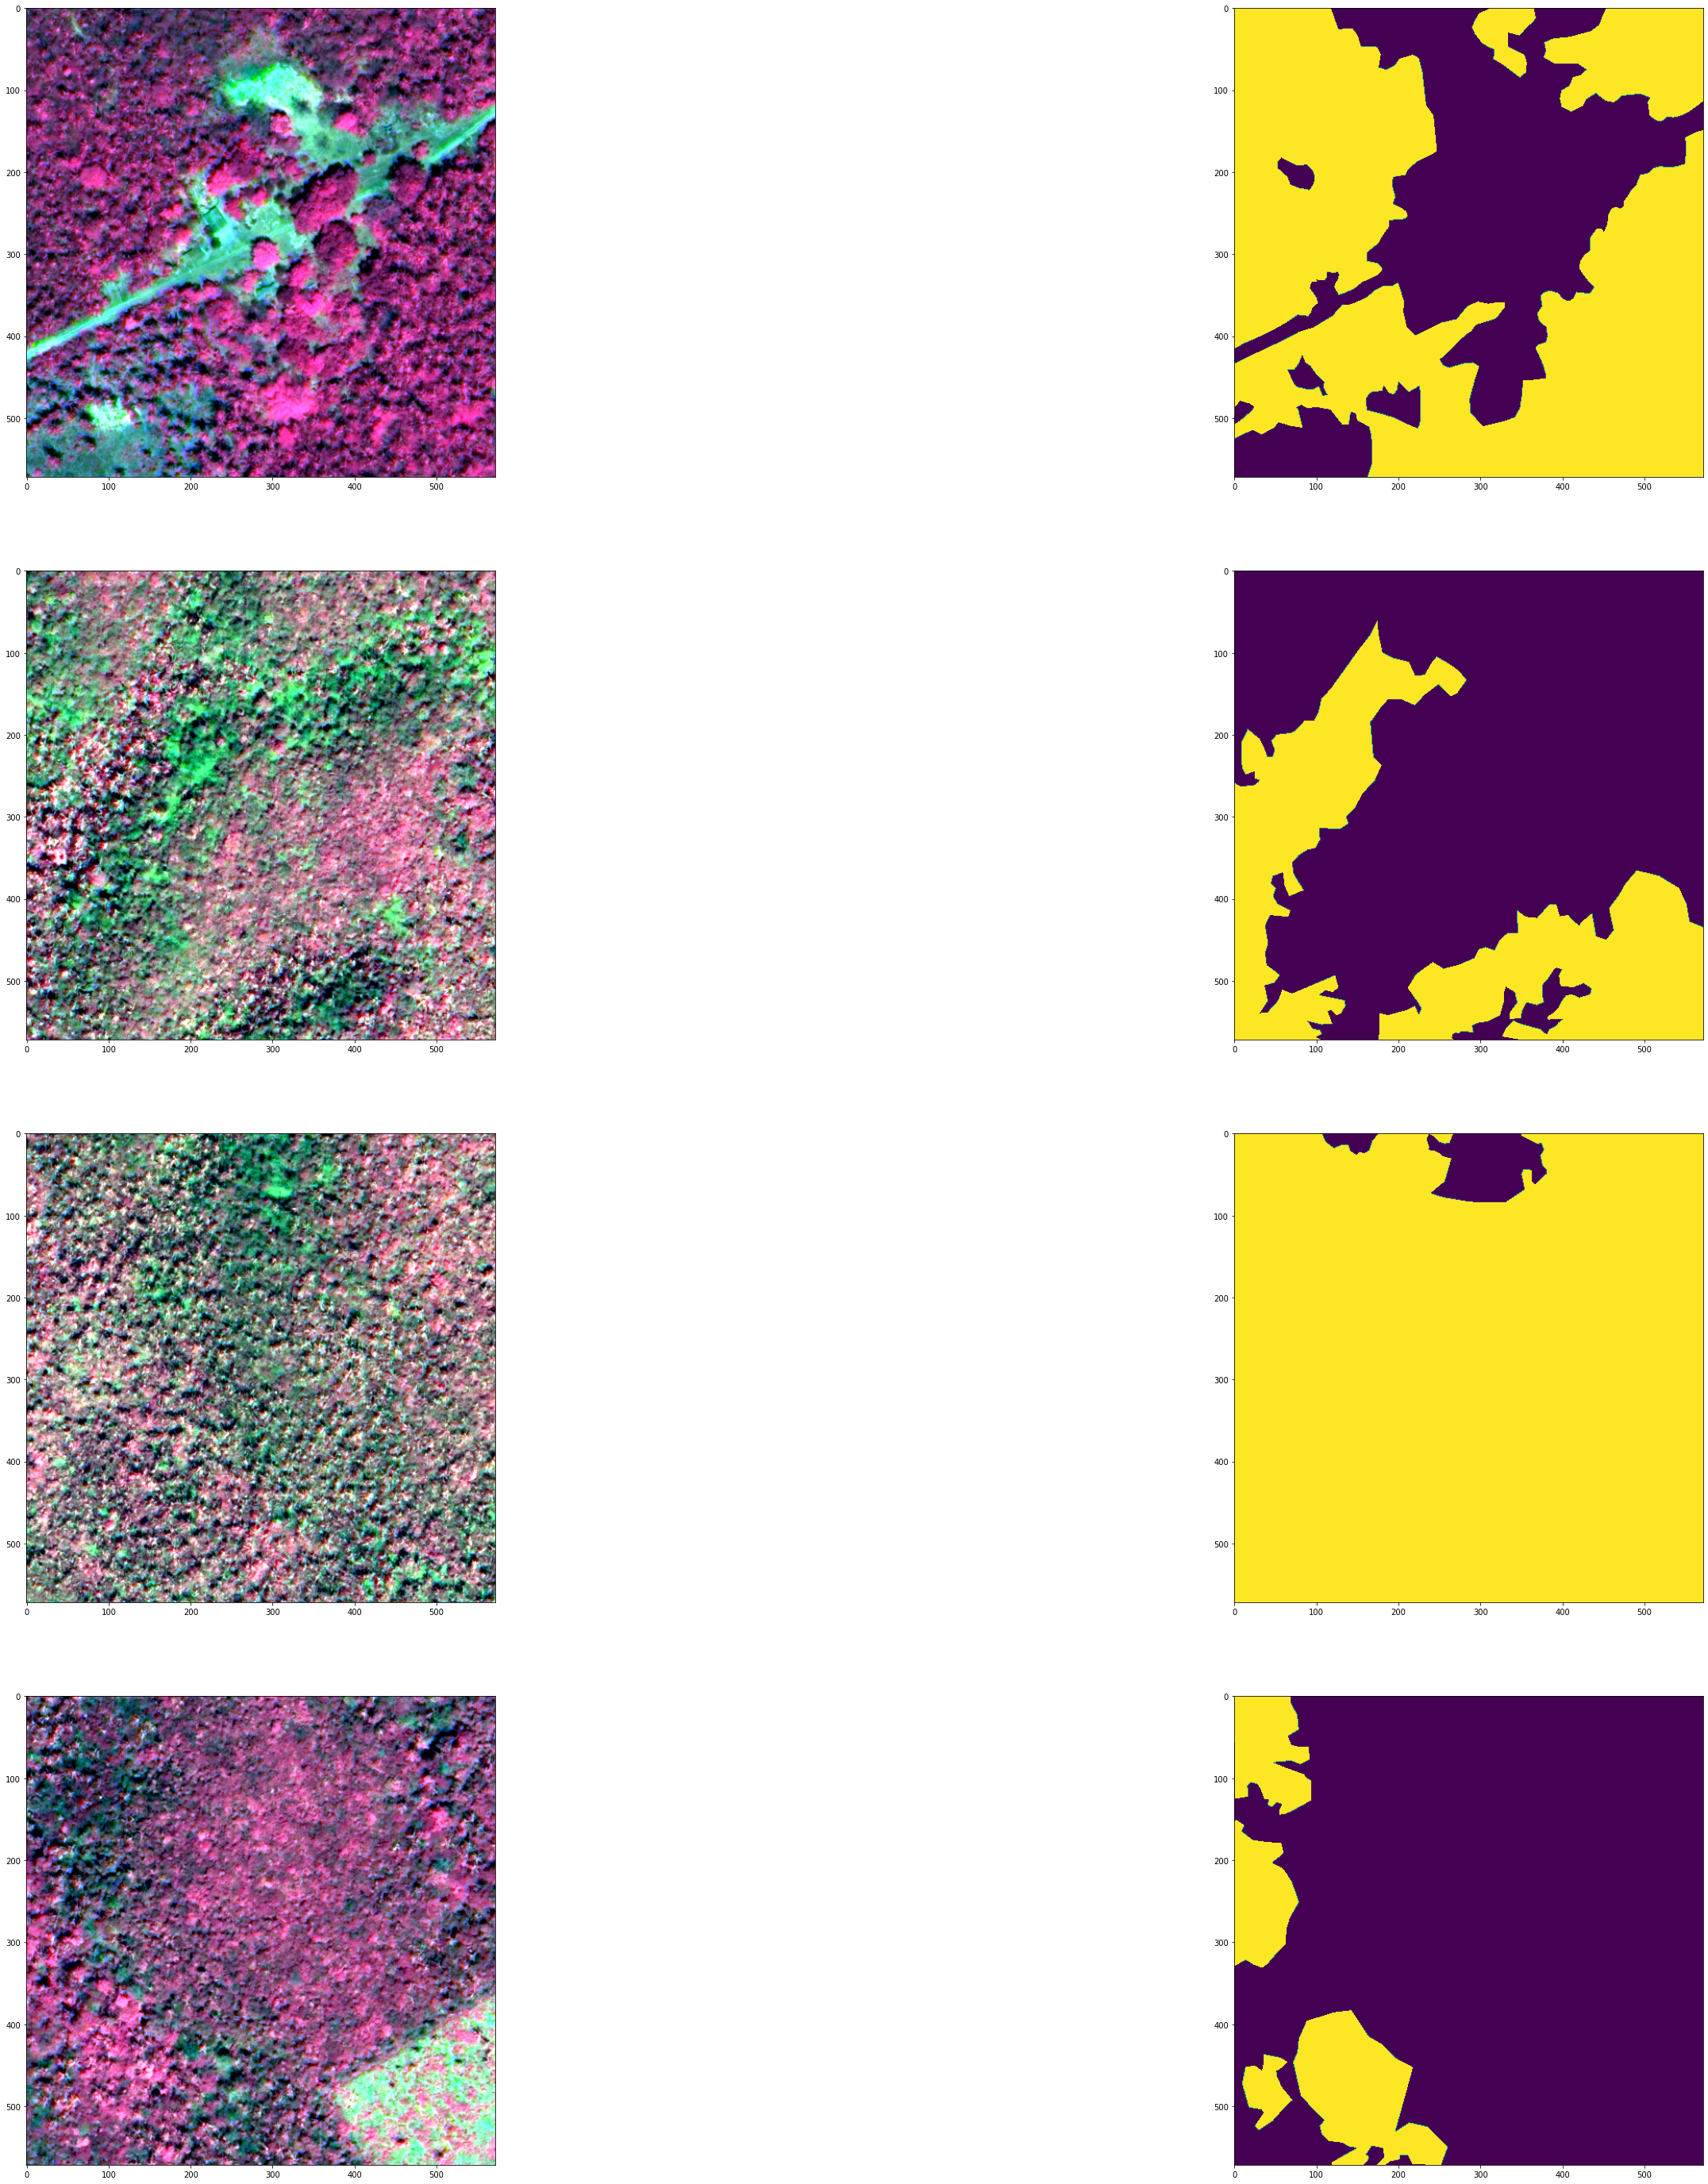

In [4]:
indices = np.random.choice(47, 4, replace=False)

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(50, 50))

plt.subplot(4, 2, 1)
img = vis.plot_rgb_img(sample_imgs[indices[0]],
                       bands=[3,2,0],
                       contrast=True,
                       onlyreturn=True)
plt.imshow(img)
plt.subplot(4, 2, 2)
plt.imshow(label_imgs[indices[0]])

plt.subplot(4, 2, 3)
img = vis.plot_rgb_img(sample_imgs[indices[1]],
                       bands=[3,2,0],
                       contrast=True,
                       onlyreturn=True)
plt.imshow(img)
plt.subplot(4, 2, 4)
plt.imshow(label_imgs[indices[1]])

plt.subplot(4, 2, 5)
img = vis.plot_rgb_img(sample_imgs[indices[2]],
                       bands=[3,2,0],
                       contrast=True,
                       onlyreturn=True)
plt.imshow(img)
plt.subplot(4, 2, 6)
plt.imshow(label_imgs[indices[2]])

plt.subplot(4, 2, 7)
img = vis.plot_rgb_img(sample_imgs[indices[3]],
                       bands=[3,2,0],
                       contrast=True,
                       onlyreturn=True)
plt.imshow(img)
plt.subplot(4, 2, 8)
plt.imshow(label_imgs[indices[3]])

plt.show()


In [5]:
dataset_description = {'years': 2018,
                       'range': {"min":0, "max":1},
                       'standardization': 'norm_range',
                       'indexes_to_compute': 'none',
                       'bands': ['b1', 'b2', 'b3', 'b4'],
                       'sensor': 'Worldview',
                       'classes': ['nopalm', 'palm'],
                       'img_no_data': -1,
                       'chip_size': 572,
                       'tolerance_nodata': .9,
                       'notes': 'Palm experiments.'}

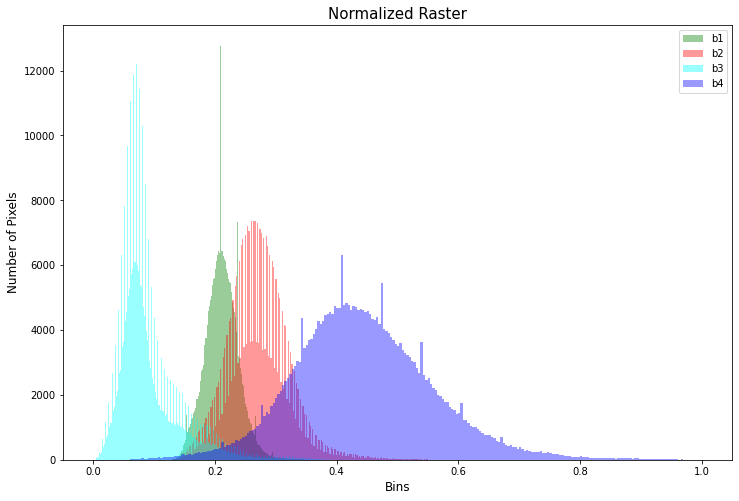

In [6]:
vis.plot_image_histogram(sample_imgs[indices[0]], cmap=["green", "red", "cyan", "blue"],
                         title="Normalized Raster", legend=dataset_description['bands'])

In [7]:
output_ds = "../data/training2"
ds_file_name = "dataset"
model_dir = '../data/training2/model'

In [8]:
train_tfrecord = os.path.join(output_ds, 'dataset_train.tfrecord')
test_tfrecord = os.path.join(output_ds, 'dataset_test.tfrecord')
val_dataset = os.path.join(output_ds, 'dataset_valid.npz')

In [9]:
generator = dg.DatasetGenerator(sample_imgs,
                                label_imgs,
                                strategy='fileset',
                                description=dataset_description)
params = {'win_size': dataset_description['chip_size'], 'overlap': (0,0)}
generator.generate_chips(params)
chip_struct = generator.get_samples()

  -> Generating chips...


In [10]:
generator.shuffle_ds()
generator.split_ds(perc_test=10, perc_val=10)

  -> Shuffling Dataset...
  -> Splitting Dataset...


In [11]:
chip_struct = generator.get_samples()
print(chip_struct.keys())

dict_keys(['train', 'test', 'valid'])


In [12]:
generator.save_to_disk(output_ds, ds_file_name)

  -> Saving Datasets to disk...
  -> DONE!


In [13]:
params = {
    'network': 'unet',
    'epochs': 10000,
    'batch_size': 4,
    'chip_size': dataset_description['chip_size'],
    'bands': 4,
    'learning_rate': 0.01,
    'learning_rate_decay': True,
    'decay_rate': 0.999,
    'l2_reg_rate': 0.0005,
    'chips_tensorboard': 2,
    'loss_func': 'avg_soft_dice',
    'data_aug_ops': ['rot90', 'rot180', 'rot270', 'flip_left_right',
                     'flip_up_down', 'flip_transpose'],
    'data_aug_per_chip': 4,
    'num_classes': 3,
    'class_names': ['nodata', 'nopalm', 'palm'],
    'num_compositions': 1,
    'bands_plot': [[3, 2, 0]],
    'Notes': 'Palm experiment.'
}

In [14]:
model = mb.ModelBuilder(params)

In [15]:
%%capture output
model.train(train_tfrecord, test_tfrecord, model_dir)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')
INFO:tensorflow:Initializing RunConfig with distribution strategies.
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Using config: {'_model_dir': '/home/evandro.taquary/deepgeo/data/training2/model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': <tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x7f64b6e870f0>, '_device_fn': None, '_protocol': None, '_eval_d

KeyboardInterrupt: 



Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/evandro.taquary/deepgeo/data/training2/model/model.ckpt-70737
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:681: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/evandro.taquary/deepgeo/src/deepgeo/dataset/../commo

<<------------------------------------------------------------>>
<<------------------ Validation Results ---------------------->>
<<------------------------------------------------------------>>
F1-Score:
Precision:
  - nodata: 0.7748864900119572
  - nopalm: 0.9420190892014012
  - palm: 0.0
Recall:
  - nodata: 0.9240763823104153
  - nopalm: 0.8212607747889303
  - palm: 0.0
Accuracy: 0.8623551918376023
AUC-ROC nodata: {'nodata': 0.9223176329735197, 'nopalm': 0.9377091924363441, 'palm': nan}
AUC-ROC nopalm: {'nodata': 0.9223176329735197, 'nopalm': 0.9377091924363441, 'palm': nan}
AUC-ROC palm: {'nodata': 0.9223176329735197, 'nopalm': 0.9377091924363441, 'palm': nan}
Classification Report:
              precision    recall  f1-score   support

      nodata     0.7749    0.9241    0.8429    300855
      nopalm     0.9420    0.8213    0.8775    451865
        palm     0.0000    0.0000    0.0000         0

    accuracy                         0.8624    752720
   macro avg     0.5723    0.581

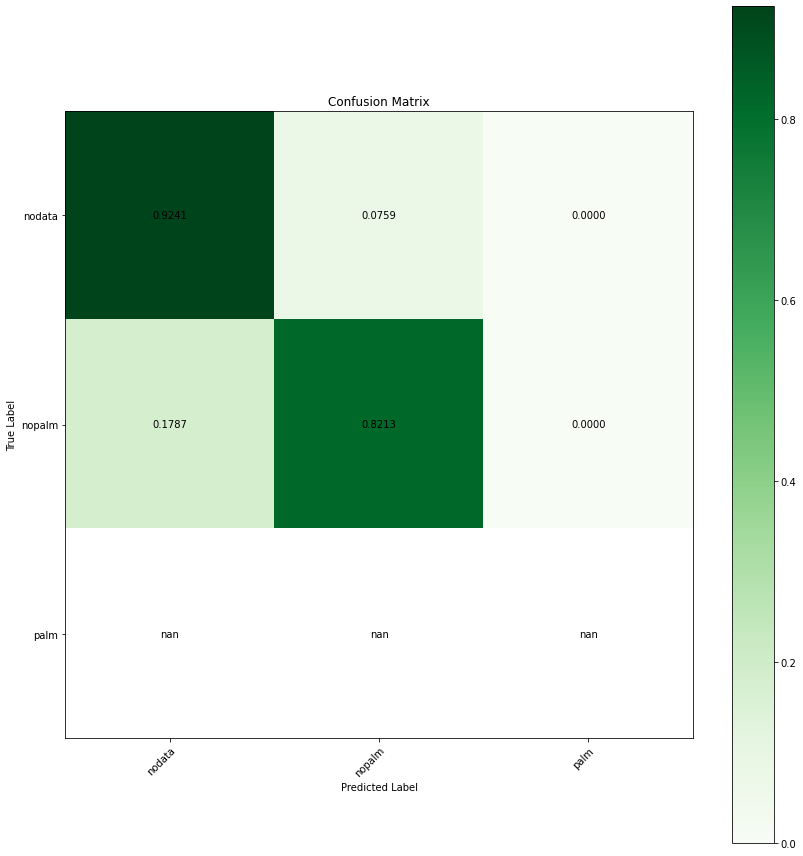

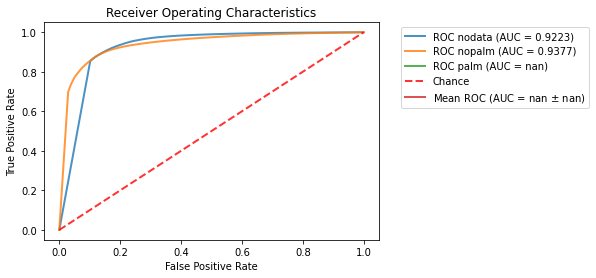

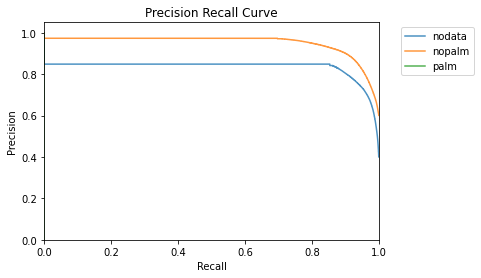

In [16]:
model = mb.ModelBuilder(model_dir)
dataset = np.load(val_dataset)
model.validate(dataset['chips'], dataset['labels'], model_dir, exclude_classes=[])

In [ ]:
# download = drive_auth.CreateFile({'id': '1AT-An70SGEGbgs9MOpWO3j1J39w6Fvv9'})
# download.GetContentFile('PDigital2018_22563_shp.zip')
# !unzip PDigital2018_22563_shp.zip

In [17]:
 test_raster_file = '../data/cocais.tif'
 #test_shape_file = 'resources/2018/PDigital2018_22563__pol.shp'

In [ ]:
#out_labels_test = "resources/labels_test.tiff"

In [18]:
preproc = prep.Preprocessor(test_raster_file, no_data=-1)
preproc.standardize_image('norm_range', {"min":0, "max":1})
raster_array = preproc.get_array_stacked_raster()

params_cg = {'overlap': [184, 184],
             'win_size': dataset_description['chip_size'],
             'raster_array': raster_array}

'''
generator = dg.DatasetGenerator(raster_array,
                                rasterized_layer,
                                strategy='sequential',
                                description=dataset_description)
generator.generate_chips(params_cg)
chip_struct = generator.get_samples()
'''
import deepgeo.dataset.sequential_chips as seqchips
chip_struct = seqchips.SequentialChipGenerator(params_cg).generate_chips()

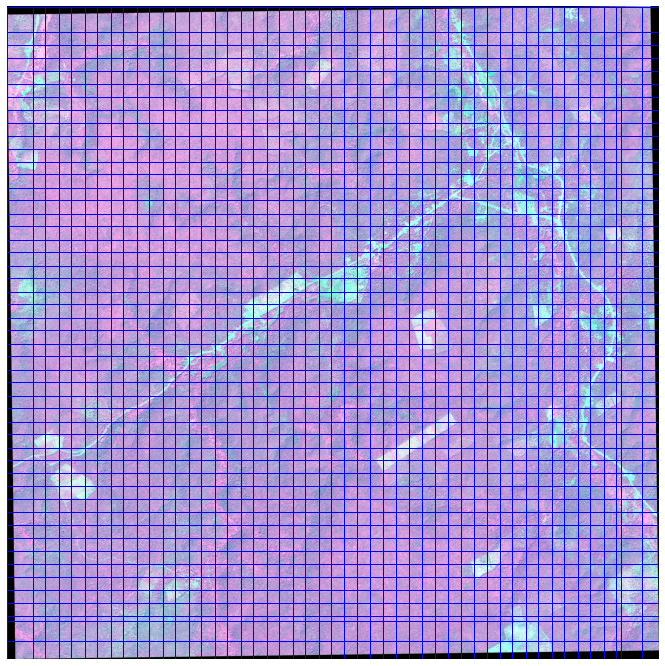

In [19]:
vis.plot_chips(chip_struct, raster_array, bands=[3, 2, 0], contrast=True)

In [20]:
# trained_model = 'training_log'
trained_model = model_dir

model = mb.ModelBuilder(trained_model)
chips = model.predict(chip_struct, model_dir=trained_model)

Classifying image with structure  (676, 572, 572, 4) ...
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/evandro.taquary/deepgeo/data/training2/model/model.ckpt-70737
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [23]:
chips.keys()

dict_keys(['chips', 'coords', 'overlap', 'predict', 'probabilities'])

In [24]:
  output_pred = "../data/training2/probabilities.tif"
  gf.write_pred_chips(output_pred, test_raster_file, chips, chip_key='probabilities')

ValueError: There are 4 color bins including extensions, but ncolors = 2; ncolors must equal or exceed the number of bins

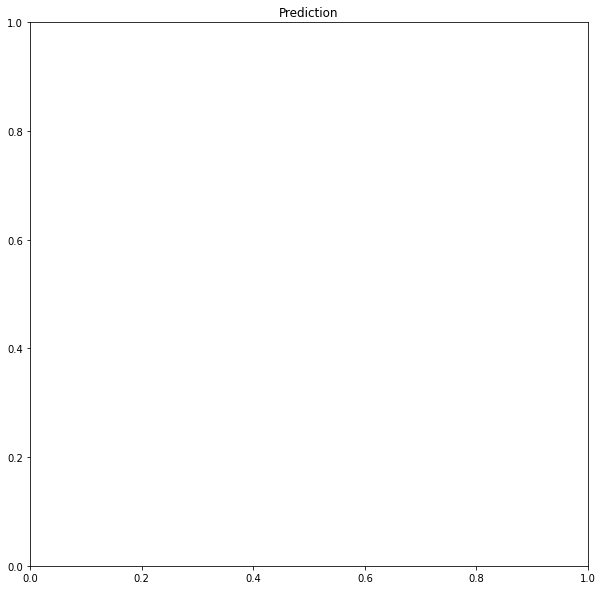

In [25]:
pred_rarr = gdal.Open(output_pred).ReadAsArray()
vis.plot_labels(pred_rarr, params['class_names'], colors=['green', 'yellow'], title='Prediction')